In [156]:
%matplotlib inline
import numpy as np
from sympy import *
import sympy
from mpmath import *
import pylab
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from IPython.parallel import Client

pool = Client()

In [446]:
def norm_points(points, high=None, low=None):
    if high is None:
        high = np.max(points)
    if low is None:
        low = np.min(points)
    return Matrix((points-low)/float(high - low))

def cor(x, x_prime, delta):
    def m(i, j):
        #print x[i, j], x_prime[i, j], delta[i]
        return ((x[i, j]-x_prime[i, j])/delta[i])**2
    return exp(-sum(Matrix(x.rows, x.cols, m)))

def cov(x, x_prime, delta, sigma_squared):
    return sigma_squared*cor(x, x_prime, delta)

def pi_star_delta(sigma_hat_sq, n, q, A_inv, A, H):
    return power(sigma_hat_sq, -(n-q)/2.)*power(A.det(), -1/2.)*power((H.T*A_inv*H).det(), -1/2.)

def sigma_hat_sq(n, q, f_D, A_inv, H):
    return (((n-q-2)**-1.)*f_D.T*(A_inv-A_inv*H*((H.T*A_inv*H)**-1)*H.T*A_inv)*f_D)[0, 0]

def sigma_hat_sq_beta(n, q, f_D, A_inv, H_, beta_hat):
    return ((f_D-H_*beta_hat).T*A_inv*(f_D-H_*(beta_hat)))/(n-q-2.)

def A(points, delta):
    def m(i, j):
        #print "next", points[:,i], points[:,j], delta
        return cor(points[:,i], points[:,j], delta)
    a = Matrix(points.cols, points.cols, m)
    return a

def fast_A(points, delta):
    scales = diag(map(lambda x: mpf(1)/x**2, delta))
    #print points, scales
    R = points.T * scales * points
    S = Matrix([diag(R).T] * R.cols)
    A = (R + R.T - S - S.T).applyfunc(exp)
    return A

def tau(delta):
    return 2*np.log(delta)

def pi_star_tau(n, q, f_D, A_inv, A, H):
    return pi_star_delta(sigma_hat_sq(n, q, f_D, A_inv, H), n, q, A_inv, A, H)

def H(x, h):
    return h(x).T

def beta_hat(H, A_inv, f_D):
    return ((H.T*A_inv*H)**-1)*H.T*A_inv*f_D

def h(x):
    return Matrix(np.ones(x.cols)).T.col_join(x)

def mahalanobis(f_D, m_star, v_star):
    return (f_D - m_star).T*(v_star**-1)*(f_D - m_star)

def se(f_D, m_star, v_star):
    return (f_D - m_star).T / diag(v_star).applyfunc(sqrt)

def make_t(D, delta_hat):
    def f(x):
        def m(i, j):
            return cor(D[:,i], x[:,j], delta_hat)
        a = Matrix(D.cols, x.cols, m)
        return a
    return f

def make_m_star(h, b_hat, A_inv, f_D, t):
    def f(x):
        return h(x).T*b_hat + t(x).T*A_inv*(f_D - H_*b_hat)
    return f

def make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t):    
    def f(x, x_prime):
        def m(i, j):
            return cor(x[:,i], x_prime[:,j], delta_hat)
        c_x_x_prime = Matrix(x.cols, x_prime.cols, m)
        return d_hat_sq*(c_x_x_prime - t(x).T*A_inv*t(x_prime) + (h(x).T-t(x).T*A_inv*H_)*((H_.T*A_inv*H_)**-1)*((h(x_prime).T-t(x_prime).T*A_inv*H_).T))
    return f

def diag(x):
    def m(i, j):
        return x[i, i]
    try:
        a = Matrix(x.cols, 1, m)
    except:
        a = sympy.diag(*x)
    return a

def fit(n, q, f_D, D, h, start):
    def f(x):
        x = Matrix(map(lambda y: exp(mpf(y)/2.), x))
        a = A(D, x)
        a_inv = a**-1
        return -log(pi_star_tau(n, q, f_D, a_inv, a, H(D, h)))
    tau = minimize(f, start, method="nelder-mead", options={'disp':True})['x']
    delta_hat = map(exp, map(lambda x: x/2., map(mpf,tau)))
    return delta_hat

def W(H, A_inv):
    return (H.T*A_inv*H)**-1

def G(A_inv, H):
    return A_inv*H

def e(A_inv, f_F, H, beta_hat):
    return A_inv*(f_D - H*beta_hat)

def E(r_h, b_hat, r_t, e):
    return r_h.T*b_hat + r_t.T*e

def V(sigma, u, r_t, A_inv, r_h, g, w):
    res = Matrix([u])
    res -= r_t.T*A_inv*r_t
    res += (r_h - g.T*r_t).T*w*(r_h-g.T*r_t)
    res *= sigma
    return sigma*(u - r_t.T*A_inv*r_t + (r_h - g.T*r_t).T*w*(r_h-g.T*r_t))

def E_var(i_i, i_2, V_, E_):
    (i_i-v)
    (i_2 - power(E_, 2.))
    return (i_i-v) + (i_2 - power(E_, 2.))

def R_w(m, x, w_bar, w):
    """
    1xq vector
    """
    #return np.hstack(([1], m.T[0, w_bar], x.T[0, w]))
    #return np.hstack(([1], x.T[0, w], m.T[0, w_bar]))
    indices = w+w_bar
    indices.sort()
    return Matrix([1]).row_join(Matrix(map(lambda k: x.T[0, k] if k in w else m.T[0, k], indices)).T)

def T_w(xw, x, b, c, m, w, w_bar, v):
    return Matrix(1, x.cols, lambda foo, k: T_w_element(xw, x, B, C, m, w, w_bar, v, k))

def T_w_element(xw, x, b, c, m, w, w_bar, v, k):
    """
    1xn vector, R_t is a special case for w is empty
    """
    #print xw, x, b, c, m, w, w_bar, v, k
    exp2 = exp(-0.5*(xw[w]-x[w,k])*2*c[w,w]*(xw[w]-x[w,k]))
    def exp1(i):
        return exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i] + b[i, i]))*power(x[i,k]-m[i], 2.))
    def div(i):
        return sqrt(b[i,i])/sqrt(2*c[i,i] + b[i,i])
    return (1 - v)*reduce(mul, map(lambda i: div(i)*exp1(i)*exp2, w_bar))

def posterior_mean_m_w(r_w, b_hat, t_w, e_):
    return r_w*b_hat + t_w*e_

def posterior_mean_i(r_i, r_h, t_i, r_t, b_hat, e_):
    return (r_i - r_h.T)*b_hat + (t_i - r_t.T)*e_


def posterior_mean_ij(r_ij, r_i, r_j, r, b_hat, t_ij, t_i, t_j, t, e_):
    """
    Interaction effects
    """
    return (r_ij - r_i - r_j - r)*b_hat + (t_ij - t_i - t*e_)

def posterior_mean_v_w(sigma, beta, A_inv, e_, w, H, u, u_w, p_w, q_w, r, t):
    """
    Sensitivity variance
    """
    term = q_w - s_w*A_inv*H
    term -= H.T*A_inv*s_w.T
    term += H.T*A_inv*p_w*A_inv*H
    
    result = u_w-Trace(A_inv*p_w) 
    result += Trace(w*term)
    result *= sigma
    result += (e_.T*p_w*e_)[0]
    result += (2*beta.T*s_w*e_)[0]
    result += (beta.T*q_w*beta)[0]
    #second term
    rtah = r-t*A_inv*H
    result -= (sigma*(u-t*A_inv*t.T + rtah*w*rtah.T))[0]
    result -= power((r*beta + t*e_)[0], 2.)
    return result

def posterior_mean_v_tw():
    return

def I_1(sigma, A_inv, r_tt, w, r_hh, r_ht, g):
    1-Trace(A_inv*r_tt)
    Trace(w*(r_hh - 2*r_ht*g + g.T*r_tt*g))
    return sigma*(mpf(1)-Trace(A_inv*r_tt) + Trace(w*(r_hh - 2*r_ht*g + g.T*r_tt*g)))

def I_2(beta, r_hh, r_ht, e_, r_tt):
    return beta.T*r_hh*beta + 2*beta.T*r_ht*e_ + e_.T*r_tt*e_

def I_3(sigma_quad, s_, A_inv, u_tt, r_tt, r_ht, w, u_hh, u_ht, g):
    return sigma_quad*(s_ - 2*Trace(A_inv)*u_tt + t*r*A_inv*r_tt*A_inv*r_tt + 2*Trace(w)*(u_hh - 2*u_ht*u + g.T*u_tt*g) - 2*t*r*A_inv*(r_ht-g.T*r_tt).T*w*(r_ht-g.T*r_tt) + Trace(w)*(r_hh - 2*r_ht*g + g.T*r_tt*g)*w*(r_hh - 2*r_ht*g + g.T*r_tt*g))

def I_4(sigma, beta, U_hh, U_ht, U_tt, e, R_ht, R_tt, R_hh, G, W, A_inv):
    return sigma*(beta.T.dot(U_hh).dot(beta) + 2*beta.T.dot(U_ht).dot(e) + e.T.dot(U_tt).dot(e) - beta.T.dot(R_ht).dot(A_inv).dot(R_ht.T).dot(beta) - 2*beta.T.dot(R_ht).dot(A_inv).dot(R_tt).dot(e) - e.T.dot(R_tt).dot(A_inv).dot(R_tt).dot(e) + (R_hh.dot(beta) - G.T.dot(R_ht.T).dot(beta) + R_ht.dot(e) -G.T.dot(R_tt).dot(e)).T.dot(W).dot(R_hh.dot(beta) - G.T.dot(R_ht.T).dot(beta) + R_ht.dot(e) - G.T.dot(R_tt).dot(e)))

def I_5(sigma_quad, S, A_inv, U_t, U_h, R_ht, R_t, R_tt, R_h, G, W):
    return delta_quad*(S-2*R_t.T.dot(A_inv).dot(U_t) + R_t.T.dot(A_inv).dot(R_tt).dot(A_inv).dot(R_t) + 2*(U_h - G.T.dot(U_t)).T.dot(W).dot(R_h - G.T.dot(R_t)) - 2*R_t.T.dot(A_inv).dot(R_ht.T-R_tt.dot(G)).dot(W).dot(R_h - G.T.dot(R_t)) + (R_h - G.T.dot(R_t)).T.dot(W).dot(R_hh - 2*R_ht.dot(G) + G.T.dot(R_tt).dot(G)).dot(W).dot(R_h - G.T.dot(R_t)))

def I_6(sigma, beta, U_h, U_t, R_ht, R_t, R_hh, R_h, A_inv, G, W, e):
    return sigma*(beta.T.dot(U_h) - beta.T.dot(R_ht).dot(A_inv).dot(R_t) + beta.T.dot(R_hh - R_ht.dot(G)).dot(W).dot(R_h - G.T.dot(R_t)) + e.T.dot(U_t) - e.T.dot(R_tt).dot(A_inv).dot(R_t) + e.T.dot((R_ht - G.T.dot(R_tt)).T).dot(W).dot(R_h - G.T.dot(R_t)))

def Q_k(x, xk, m, B, C):
    return (2*(x - xk).T*C*(x - xk) + (x-m).T*B*(x-m))[0,0]

def m_k(x, C, B, m):
    return ((2*C + B)**-1)*(2*C*x + B*m)

def R_h(m):
    return Matrix([1]).col_join(m)

def R_hh(m, B):
    #np.vstack((np.hstack(([[1]], m.T)), np.hstack((m, m.dot(m.T) + B.getI()))))
    return Matrix([1]).row_join(m.T).col_join(m.row_join(m*m.T + B**-1))

def R_t(D, B, C, v, m):
    return Matrix(map(lambda k: R_t_elem(D, k, B, C, v, m), range(D.cols)))

def R_t_elem(X, k, B, C, v, m):
    X = X[:,k]
    m_prime_k = m_k(X, C, B, m)
    q_k = Q_k(m_prime_k, X, m, B, C)
    
    return (1-v)*power(det(B), 0.5)*power(det(2*C + B), -0.5)*exp(-q_k/2.)

def R_ht(D, B, C, v, m, h):
    return reduce(lambda x, y: x.row_join(y),map(lambda k: R_ht_elem(D, k, B, C, v, m, h), range(D.cols))) #matrix

def R_ht_elem(X, k, B, C, v, m, h):
    x = X[:,k]
    m_prime_k = m_k(x, C, B, m)
    return R_t(X, k, B, C, v, m)*Matrix([1]).col_join(m_prime_k)

def Q_kl(x, xk, xl, C, B, m):
    return 2*(x - xk).T*C*(x - xk) + 2*(x - xl).T*C*(x - xl) + (x - m).T*B*(x - m)

def m_kl(xk, xl, C, B, m):
    return ((4*C + B)**-1)*(2*C*xk + 2*C*xl + B*m)

def R_tt(D, C, B, m, v):
    return Matrix(D.cols, D.cols, lambda i, j: R_tt_element(D, i, j, C, B, m, v))

def R_tt_element(x, k, l, C, B, m, v):
    xk = x[:,k]
    xl = x[:,l]
    qkl = Q_kl(m_kl(xk, xl, C, B, m), xk, xl, C, B, m)[0,0]
    return power(1-v, 2.)*power(det(B), 0.5)*power(det(4*C + B), -0.5)*exp(- qkl/2.)

def Q(x, x_prime, C, B, m):
    return 2*(x - x_prime).T.dot(C).dot(x - x_prime) + (x - m).T.dot(B).dot(x - m) + (x_prime - m).T.dot(B).dot(x_prime - m)

def x_stack(x, x_prime):
    return np.vstack((x, x_prime))

def m_stack(m):
    return np.vstack((m, m))

def B_stack(B, C):
    return (2*C + B).row_join(-2*C).col_join((-2*C).row_join(2*C+B))

def U(v, B, C):
    return (1 - v)*det(B)*power(det(B_stack(B, C)), -0.5)

def U_h(v, B, C, m, X, h):
    return U(v, B, C)*expectation(h(X), m_stack(m), B_stack(B, C))

def U_hh(v, B, C, m, X, X_prime, h):
    return U(v, B, C)*expectation(h(X).dot(h(X_prime).T), m_stack(m), B_stack(B, C))

def Q_uk(x, x_prime, C, m, B, k):
    return 2*(x_prime - x[k]).T.dot(C).dot(x_prime - x[k]) + 2*(x - x_prime).T.dot(C).dot(x - x_prime) + (x - m).T.dot(B).dot(x - m) + (x_prime - m).T.B.dot(x_prime - m)

def m_k_stack(B, m, C, x, k):
    return B.getI().dot(np.vstack((B.dot(m), 2*C.dot(x[k]) + B.dot(m))))

def B_k_stack(B, C):
    return np.vstack((np.hstack((4*C + B, -2*C)), np.hstack((-2*C, 4*C+B))))

def U_t(B, C, x, k, m, v):
    quk = Q_uk(x, C, x, B, k)
    return np.power(1 - v, 2.)*np.linalg.det(B)*np.power(np.linalg.det(B_k_stack(B, C)), -0.5)*np.exp(-quk/2.)

def U_ht(B, C, x, k, m, v):
    return U_t(B, C, x, k, m, v)*expectation(h(X), m_k_stack(B, m, C, x, k, X), B_k_stack(B, C))

def Q_ukl():
    return 2*(x - x_prime).T.dot(C).dot(x - x_prime) + Q(x, x_prime, C, m, B, k) 

## Sensitivity special case 2

def U_w(v, b, c, w_bar):
    return (1 - v)*reduce(mul, map(lambda i: power(b[i, i]/(b[i, i]+2*(2*c[i, i])), 0.5), w_bar))

def P_w(x, m, b, c, w):
    return Matrix(x.cols, x.cols, lambda k, l: P_w_element(x, k, l, m, B, C, w))

def P_w_element(x, k, l, m, b, c, w):
    """
    nxn matrix
    """
    def term_1(i):
        return (b[i, i]/(2*c[i, i] + b[i, i]))*exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i]+b[i, i]))*(power(x[i, k] - m[i], 2.) + power(x[i, l]-m[i], 2.)))
    def term_2(i):
        return power(b[i,i]/(4*c[i,i] + b[i, i]), 0.5)*exp(-0.5*(1/(4*c[i, i] + b[i, i]))*(4*power(c[i,i], 2.)*power(x[i,k]-x[i,l],2.0) + 2*c[i,i]*b[i,i]*(power(x[i,k]-m[i], 2.) + power(x[i,l]-m[i], 2.))))
    return power(1 - v, 2.)*reduce(mul, map(term_1, w_bar))*reduce(mul, map(term_2, w))

def P(r_t):
    return r_t.T*r_t

def S_w(w, w_bar, b, c, x, m, v):
    return Matrix(x.cols, q, lambda l, k: S_w_element(k, l, w, w_bar, B, C, x, m, v)).T

def S_w_element(k, l, w, w_bar, b, c, x, m, v):
    """
    qxn matrix
    """
    h_k = 1
    k -= 1
    if k in w_bar:
        h_k = m[k]
    elif k in w:
        h_k = (2*c[k,k]*x[k, l] + b[k, k]*m[k])/(2*c[k, k] + b[k, k])
    def t2(i):
        return power(b[i, i], .5) / power(2*c[i,i] + b[i, i], 0.5)*exp(-0.5*(((2*c[i, i]*b[i,i])/(2*c[i, i] + b[i, i]))*power(x[i, l] - m[i], 2.)))
    return (1 - v)*h_k*reduce(lambda x, y: x*y, map(t2, w + w_bar))

def S(r_h, r_t):
    return r_h.T*r_t

def Q_w(m, w, w_bar, b):
    """
    qxq matrix
    """
    indices = w+w_bar
    indices.sort()
    
    def swap_cols(arr):
        x = a.col_insert(1,q_w[:,q_w.cols-1])
        x.col_del(x.cols-1)
    def swap_rows(arr, frm, to):
        arr[[frm, to],:] = arr[[to, frm],:]
    
    result = Matrix([1]).row_join(m[w_bar,0].T).row_join(m[w,0].T)
    result = result.col_join(m[w_bar,0].row_join(m[w_bar,0]*m[w_bar,0].T).row_join(m[w_bar,0]* m[w,0].T))
    result = result.col_join(m[w,0].row_join(m[w,0]* m[w_bar,0].T).row_join(m[w,0]*m[w,0].T + (B**-1)[w, w]))
    if w[0] < w_bar[0]:
        x = result.col_insert(1,result[:,result.cols-1])
        x.col_del(x.cols-1)
        result = x.row_insert(1, x[x.rows-1,:])
        result.row_del(result.rows-1)
    return result
    
def Q(r_h):
    return r_h.T*r_h

def Trace(x):
    return sum(diag(x))

In [191]:
R = D.T*diag(delta_hat)*D
S = Matrix([diag(R).T]*R.cols)
A(D, delta_hat) - fast_A(D, delta_hat)

Matrix([
[                    0,  -2.0870891820346e-18,                     0, -2.72004641033163e-15,  6.93889390390723e-16, -1.38666955995881e-31, -3.79662976464769e-26,                     0,                     0,  1.14491749414469e-16,  2.77555756156289e-17, -3.17637355220363e-21,  2.08166817117217e-17,  1.58206781009085e-15, -3.03576608295941e-18, -4.23704587765192e-33, -1.14100841331167e-26,   7.6232965252887e-21, -6.66133814775094e-16,  9.54097911787244e-17, -3.14418630020796e-18,  9.71445146547012e-17,  8.88178419700125e-15,  7.63278329429795e-17,   -8.470329472543e-20,  1.35525271560688e-19,                     0,  3.66373598126302e-15,                     0, -1.08567455397585e-24,                     0, -6.10622663543836e-16, -3.64291929955129e-17, -1.77635683940025e-15, -8.23993651088983e-18,   4.9960036108132e-15, -7.37257477290143e-18, -1.10966666717624e-35, -8.65954703766451e-25, -3.14418630020796e-18],
[-2.98155597433514e-18,                     0,                     0,

In [ ]:
def lhc(p, n):
    u = np.random.random((p, n))
    b = np.array(np.random.permutation(range(0, n)))
    for i in range(p - 1):
        b = np.vstack((b, np.array(np.random.permutation(range(0, n)))))
    return(b + u) / float(n)

def maximin_criterion(D):
    return np.nanmin(D.T.dot(D))
    
def maximin_lhc(K, p, n):
    D_max = lhc(p, n)
    high = maximin_criterion(D_max)
    for i in range(K):
        D = lhc(p, n)
        maximin = maximin_criterion(D_max)
        if maximin > high:
            D_max = D
            high = maximin
    return D_max

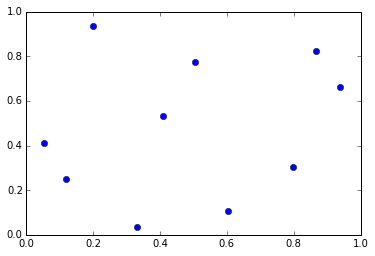

In [4]:
p = 2
n = 10
k = 500
D = maximin_lhc(k, p, n)
pylab.figure()
pylab.plot(D[0], D[1], 'o')
pylab.show()

30 2 3


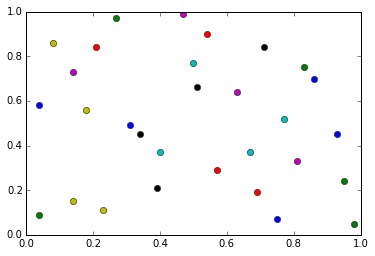

In [5]:
points = Matrix([[0.86,0.27,0.57,0.5,0.14,0.23,0.39,0.93,0.98,0.54, 0.77,0.81,0.18,0.71,0.31,0.04,0.69,0.4,0.63,0.08, 0.34,0.04,0.83,0.21,0.67,0.47,0.14,0.51,0.75,0.95],
                   [0.7,0.97,0.29,0.77,0.73,0.11,0.21,0.45,0.05,0.9, 0.52,0.33,0.56,0.84,0.49,0.09,0.19,0.37,0.64,0.86, 0.45,0.58,0.75,0.84,0.37,0.99,0.15,0.66,0.07,0.24 ]])
f_D = Matrix([[11.81,-4.95,25.51,5.27,4.85,30.28,27.50,20.89,34.50,0.43, 17.59,25.27,13.39,3.67,16.50,29.96,29.78,21.14,12.78,-0.98, 17.99,12.11,9.10,1.03,22.71,-4.61,28.33,11.60,34.10,29.28]]).T
D = points#norm_points(points)
taus = np.array(zip(*product(np.linspace(-10, 5, 25), np.linspace(-10, 10, 25)))).T#np.vstack((np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))).T
n = D.cols
p = D.rows
q = 1 + p
delta_hat = Matrix([0.4966, 0.1061]).T
print n, p, q
pylab.figure()
pylab.plot(D[0,:], D[1,:], 'o')
pylab.show()

In [6]:
D[:,0], D.T[0,:]

(Matrix([
 [0.86],
 [ 0.7]]), Matrix([[0.86, 0.7]]))

In [7]:
from multiprocessing import Pool
pool = Pool(4)

class DoA(object):
    def __init__(self, D):
        self.D = D
    def __call__(self, tau):
        return A(self.D, tau)

def mk_as():
    ts = map(lambda s: Matrix(map(lambda y: exp(mpf(y)/2.), s)).T, taus)
    return map(DoA(D), ts)
    #return pool[:].map_sync(DoA(D), ts)
As = mk_as()
H(D, h), As[0]

(Matrix([
 [1.0, 0.86,  0.7],
 [1.0, 0.27, 0.97],
 [1.0, 0.57, 0.29],
 [1.0,  0.5, 0.77],
 [1.0, 0.14, 0.73],
 [1.0, 0.23, 0.11],
 [1.0, 0.39, 0.21],
 [1.0, 0.93, 0.45],
 [1.0, 0.98, 0.05],
 [1.0, 0.54,  0.9],
 [1.0, 0.77, 0.52],
 [1.0, 0.81, 0.33],
 [1.0, 0.18, 0.56],
 [1.0, 0.71, 0.84],
 [1.0, 0.31, 0.49],
 [1.0, 0.04, 0.09],
 [1.0, 0.69, 0.19],
 [1.0,  0.4, 0.37],
 [1.0, 0.63, 0.64],
 [1.0, 0.08, 0.86],
 [1.0, 0.34, 0.45],
 [1.0, 0.04, 0.58],
 [1.0, 0.83, 0.75],
 [1.0, 0.21, 0.84],
 [1.0, 0.67, 0.37],
 [1.0, 0.47, 0.99],
 [1.0, 0.14, 0.15],
 [1.0, 0.51, 0.66],
 [1.0, 0.75, 0.07],
 [1.0, 0.95, 0.24]]), Matrix([
 [                 1.0,                   0.0,                   0.0,                   0.0,                   0.0,                  0.0,                   0.0,                   0.0, 0.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,       

In [8]:
As[10]

Matrix([
[                  1.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,   9.6166545181384e-48, 1.89894493511924e-139,                   0.0,  2.76135869105219e-78,  5.89230433746513e-25,                   0.0, 5.25472514044299e-216,                   0.0,                   0.0, 8.81713969940213e-278,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,    2.4259189389231e-9,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0, 2.18329818442017e-117,  1.06924225095622e-78],
[                  0.0,                   1.0,                   0.0,                   0.0, 1.59448453091647e-162,  9.85896862162848e-18, 8.35372979192771e-140,                   0.0,                   0.0,                   0.0,                   0.0,                   0.0,  1.34616598131314e-78,

In [20]:
A_invs = map(lambda a: a**-1, As)

In [21]:
class DoPiStar(object):
    def __call__(self, pair):
        a_inv, a = pair
        return log(pi_star_tau(n, q, f_D, a_inv, a, H(D, h)))

#pi_tau_star_pi = pool[:].map_sync(lambda (a_inv, a): pi_star_tau(n, q, f_D, a_inv, a, H(D, h)), zip(A_invs, As))
#ln_pi_tau_star_pi = map(log, pi_tau_star_pi)
def mk_pistars():
    return map(DoPiStar(), zip(A_invs, As))
    #return pool[:].map_sync(DoPiStar(), zip(A_invs, As))
ln_pi_tau_star_pi = mk_pistars()
ln_pi_tau_star_pi

[mpf('-1.1958400889044387'),
 mpf('-1.1958400888995451'),
 mpf('-1.1958400888959975'),
 mpf('-1.1958400888345786'),
 mpf('-1.1958463988680166'),
 mpf('-1.1972053592446881'),
 mpf('-1.2100716374423655'),
 mpf('-1.2354766257193259'),
 mpf('-1.2576512866345206'),
 mpf('-1.2878254482778437'),
 mpf('-1.4072236269296656'),
 mpf('-1.7862963781040446'),
 mpf('-2.7880564158094492'),
 mpf('-4.9741857339115896'),
 mpf('-8.9364197672595527'),
 mpf('-15.030501108501655'),
 mpf('-23.075868883250156'),
 mpf('-32.473134069552337'),
 mpf('-42.627095220195457'),
 mpf('-53.153289794326675'),
 mpf('-63.850757932551616'),
 mpf('-74.624582163775258'),
 mpf('-85.431964591792422'),
 mpf('-96.254002933892068'),
 mpf('-107.08242430884937'),
 mpf('-1.1958400889044387'),
 mpf('-1.1958400888999303'),
 mpf('-1.1958400762201065'),
 mpf('-1.1958392188163851'),
 mpf('-1.1958503373265226'),
 mpf('-1.199633818189892'),
 mpf('-1.2369145300527895'),
 mpf('-1.3180611044569399'),
 mpf('-1.3956263534177242'),
 mpf('-1.459115

In [ ]:
taus.T[1]

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


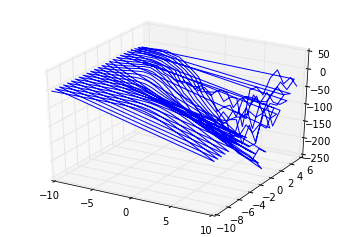

In [22]:
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(taus.T[1], taus.T[0], map(re, ln_pi_tau_star_pi))
fig.show()

In [23]:
delta_hat = fit(n, q, f_D, D, h, [ 0.49632059,  0.10587287])
print delta_hat, "[ 0.49632059  0.10587287]"

Optimization terminated successfully.
         Current function value: -11.512261
         Iterations: 71
         Function evaluations: 134
[mpf('0.49631497734800389'), mpf('0.10587354305255788')] [ 0.49632059  0.10587287]


In [24]:
#delta_hat = [ 0.49632059,  0.10587287]
A_inv = A(D, delta_hat)**-1
b_hat = beta_hat(H(D, h), A_inv, f_D)
s_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))
H_ = H(D, h)

In [25]:
b_hat, s_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

(Matrix([
 [ 33.5746747545557],
 [ 4.99711561959407],
 [-39.7265998616331]]), 1.03126065460037, Matrix([[1.03126065459991]]))

In [26]:
b_hat, s_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat) #old

(Matrix([
 [ 33.5746747545557],
 [ 4.99711561959407],
 [-39.7265998616331]]), 1.03126065460037, Matrix([[1.03126065459991]]))

In [27]:
t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(s_hat_sq, delta_hat, A_inv, h, H_, t)
D_prime = Matrix([[0.00,0.83,0.16,0.37,0.76,0.64,0.58,0.91,0.42,0.21],
[0.12,0.83,0.51,0.64,0.44,0.70,0.46,0.03,0.24,0.94]])
f_D_prime = Matrix([[28.66,4.68,15.04,11.63,20.39,10.83,18.78,34.76,26.60,-4.08]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print diag(v_star_D_prime).applyfunc(sqrt)
print se(f_D_prime, m_star_D_prime, v_star_D_prime)
#ses = matrix2numpy(se(f_D_prime, m_star_D_prime, v_star_D_prime), dtype=float)
#figure()
#plot(range(0, 10), ses[0], 'x')
#ylim([-4, 4])
#show()

Matrix([[28.6673193633471], [4.74597701570005], [15.0092545384218], [11.6445534541433], [20.4809095015493], [10.4995038760419], [18.9446192146911], [35.1970725633311], [26.5404618644235], [-3.94234321119339]])
Matrix([[0.163881460611213], [0.218596937056291], [0.285570471550341], [0.253295773358963], [0.255703726352199], [0.215651656826556], [0.336413344025286], [0.316687968736056], [0.136911436660436], [0.202750565914467]])
Matrix([[-0.00731936334706873, -0.0659770157000503, 0.0307454615782028, -0.0145534541432575, -0.0909095015492873, 0.330496123958065, -0.164619214691058, -0.437072563331093, 0.0595381355765277, -0.137656788806609]])*Matrix([
[0.163881460611213],
[0.218596937056291],
[0.285570471550341],
[0.253295773358963],
[0.255703726352199],
[0.215651656826556],
[0.336413344025286],
[0.316687968736056],
[0.136911436660436],
[0.202750565914467]])**(-1)


In [28]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

Matrix([[8.15518437591724]])

In [29]:
D.row_join(D_prime), f_D.col_join(f_D_prime)

(Matrix([
 [0.86, 0.27, 0.57,  0.5, 0.14, 0.23, 0.39, 0.93, 0.98, 0.54, 0.77, 0.81, 0.18, 0.71, 0.31, 0.04, 0.69,  0.4, 0.63, 0.08, 0.34, 0.04, 0.83, 0.21, 0.67, 0.47, 0.14, 0.51, 0.75, 0.95,  0.0, 0.83, 0.16, 0.37, 0.76, 0.64, 0.58, 0.91, 0.42, 0.21],
 [ 0.7, 0.97, 0.29, 0.77, 0.73, 0.11, 0.21, 0.45, 0.05,  0.9, 0.52, 0.33, 0.56, 0.84, 0.49, 0.09, 0.19, 0.37, 0.64, 0.86, 0.45, 0.58, 0.75, 0.84, 0.37, 0.99, 0.15, 0.66, 0.07, 0.24, 0.12, 0.83, 0.51, 0.64, 0.44,  0.7, 0.46, 0.03, 0.24, 0.94]]),
 Matrix([
 [11.81],
 [-4.95],
 [25.51],
 [ 5.27],
 [ 4.85],
 [30.28],
 [ 27.5],
 [20.89],
 [ 34.5],
 [ 0.43],
 [17.59],
 [25.27],
 [13.39],
 [ 3.67],
 [ 16.5],
 [29.96],
 [29.78],
 [21.14],
 [12.78],
 [-0.98],
 [17.99],
 [12.11],
 [  9.1],
 [ 1.03],
 [22.71],
 [-4.61],
 [28.33],
 [ 11.6],
 [ 34.1],
 [29.28],
 [28.66],
 [ 4.68],
 [15.04],
 [11.63],
 [20.39],
 [10.83],
 [18.78],
 [34.76],
 [ 26.6],
 [-4.08]]))

In [30]:
D = D.row_join(D_prime)
f_D = f_D.col_join(f_D_prime)
n = D.cols
print n

40


In [31]:
delta_hat = fit(n, q, f_D, D, h, [ 0.49632059,  0.10587287])
print delta_hat, "[ 0.49632059  0.10587287]"

Optimization terminated successfully.
         Current function value: -29.331672
         Iterations: 63
         Function evaluations: 121
[mpf('0.54421169002716085'), mpf('0.096811136316205568')] [ 0.49632059  0.10587287]


In [415]:
A_inv = A(D, delta_hat)**-1
b_hat = beta_hat(H(D, h), A_inv, f_D)
s_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))
H_ = H(D, h)
t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(s_hat_sq, delta_hat, A_inv, h, H_, t)
print b_hat, s_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

Matrix([[33.5968543783884], [4.85742321497394], [-39.6752850060554]]) 0.924357982082290 Matrix([[0.924357982085278]])


In [416]:
B = Matrix([[50, 0], [0, 50]])
C = Matrix([[power(delta_hat[0], -2.), 0], [0, power(delta_hat[1], -2.)]])
m = Matrix([.5, .5])
v = 0.
E_X_h_x = Matrix([1]).col_join(m)
E_X_h_x_h_x = E_X_h_x.T.col_join(m.row_join(m*m.T + B**-1))
m, E_X_h_x, E_X_h_x_h_x, C

(Matrix([
 [0.5],
 [0.5]]), Matrix([
 [  1],
 [0.5],
 [0.5]]), Matrix([
 [  1,  0.5,  0.5],
 [0.5, 0.27, 0.25],
 [0.5, 0.25, 0.27]]), Matrix([
 [3.37648066435445,                0],
 [               0, 106.696301324393]]))

In [417]:
r_t.T*A_inv*r_t

Matrix([[0.285629043070803]])

In [447]:
w = W(H_, A_inv)
g = G(A_inv, H_)
e_ = e(A_inv, f_D, H_, b_hat)
r_h = R_h(m)
r_t = R_t(D, B, C, v, m)
u = Matrix([U(v, B, C)])
E_ = E(r_h, b_hat, r_t, e_)
V_ = V(s_hat_sq, u, r_t, A_inv, r_h, g, w)
print E_, V_

Matrix([[16.9845125380243]]) Matrix([[0.00161840996727972]])


In [419]:
E_, V_

(Matrix([[16.9845125380243]]), Matrix([[0.00161840996727972]]))

In [445]:
#r_tt = Matrix(map(lambda k: map(lambda l: R_tt(D, k, l, C, B, m, v), range(D.cols)), range(D.cols))) #matrix
r_tt = R_tt(D, C, B, m, v)
r_hh = R_hh(m, B)
r_ht = R_ht(D, B, C, v, m, h)
#print r_tt, "---", r_hh, "---", r_ht
i_1 = I_1(s_hat_sq, A_inv, r_tt, w, r_hh, r_ht, g)
i_2 = I_2(b_hat, r_hh, r_ht, e_, r_tt)
E_var_ = E_var(i_1, i_2[0,0], V_[0,0], E_[0,0])
print E_var_, 29.9709394126

29.9709270069820 29.9709394126


5.47457094273 16.984512538


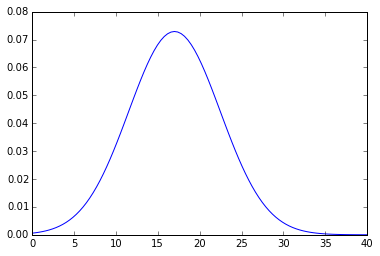

In [421]:
pylab.figure()
mean = float(E_[0,0])
variance = E_var_
sigma = float(sqrt(variance))
print sigma, mean
x = np.linspace(0,40,100)
from scipy.stats import norm
pylab.plot(x,norm.pdf(x, mean,sigma))

pylab.show()

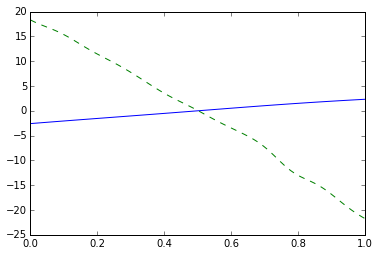

In [438]:
x = D
def calc(w, i):
    w_bar = [(w + 1) % 2]
    xw = Matrix([0., 0.])
    xw[w] = i
    xw = xw
    #print xw, i
    r_w = R_w(m, xw, w_bar, [w])
    t_w = T_w(xw, x, B, C, m, w, w_bar, v)
    #return posterior_mean_m_w(r_w, b_hat, t_w, e_)
    return posterior_mean_i(r_w, r_h, t_w, r_t, b_hat, e_)

pylab.figure()
x_axis = np.linspace(0,1,100)
pylab.plot(x_axis, map(lambda y: calc(0, y)[0, 0], x_axis))
pylab.plot(x_axis, map(lambda y: calc(1, y)[0, 0], x_axis), '--')
pylab.show()

In [434]:
w_bar = [0]
w = [1]
u_w = U_w(v, B, C, w_bar)
p_w = P_w(x, m, B, C, w)
s_w = S_w(w, w_bar, B, C, x, m, v)
q_w = Q_w(m, w, w_bar, B)
posterior_mean_v_w(sigma, b_hat, A_inv, e_, W(H_, A_inv), H_, u, u_w, p_w, q_w, r_h.T, r_t.T)

mpf('29.447695839169683')

In [433]:
w_bar = [1]
w = [0]
u_w = U_w(v, B, C, w_bar)
p_w = P_w(x, m, B, C, w)
s_w = S_w(w, w_bar, B, C, x, m, v)
q_w = Q_w(m, w, w_bar, B)
posterior_mean_v_w(sigma, b_hat, A_inv, e_, W(H_, A_inv), H_, u, u_w, p_w, q_w, r_h.T, r_t.T)

mpf('0.53476529590602695')